<a href="https://colab.research.google.com/github/crissyro/Deep-learning-courses/blob/main/notebooks/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
! unzip -qq /content/kagglecatsanddogs_5340.zip
! rm -rf /content/PetImages/Cat/666.jpg /content/PetImages/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2025-04-28 13:10:56--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.152.196, 2600:1417:3f:b88::317f, 2600:1417:3f:bb9::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.200.152.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  69.4MB/s    in 12s     

2025-04-28 13:11:08 (66.8 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
dataset = ImageFolder(
    root='/content/PetImages',
    transform=transforms.Compose(
        [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
  )
)

train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

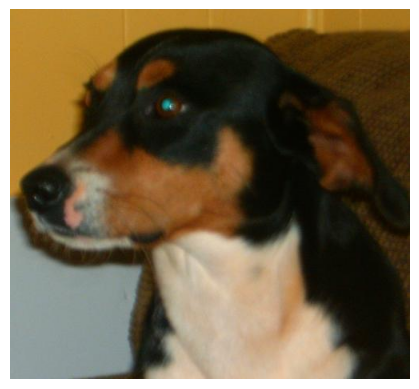

In [3]:
file = np.random.choice(glob.glob('/content/PetImages/*/*'))
img = plt.imread(file)
plt.axis('off')
plt.imshow(img);

In [ ]:
! pip install pytorch_lightning torchmetrics

In [4]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import googlenet, resnet18

In [5]:
model_resnet18 = resnet18(pretrained=True)
model_googlenet = googlenet(pretrained=True)

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [6]:
class CatsDogsResnet(pl.LightningModule):
    def __init__(self, pretrainde: bool):
        super().__init__()
        self.pretrained = pretrainde

        if pretrainde:
          self.model = resnet18(pretrained=True)
          self.model.fc = nn.Identity()
          self.classifier = nn.Linear(512, 2)
          self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)
        else:
          self.model = resnet18(pretrainde=False)
          self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        if self.pretrained:
          with torch.no_grad():
            features = self.model(x)
          preds = self.classifier(features)
        else:
          preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        img, target = train_batch
        preds = self.forward(img)
        loss = self.loss(preds, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        img, target = val_batch
        preds = self.forward(img)
        loss = self.loss(preds, target)
        acc = accuracy(
            torch.argmax(preds, dim=1).long(),
            target.long(),
            task='binary',
        )
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

In [ ]:
cats_dogs_resnet = CatsDogsResnet(pretrainde=True)

trainer = pl.Trainer(accelerator='gpu', max_epochs=10)
trainer.fit(cats_dogs_resnet, train_dataloader, val_dataloader)

In [6]:
class CatsDogsGooglenet(pl.LightningModule):
    def __init__(self, pretrainde: bool):
        super().__init__()
        self.pretrained = pretrainde

        if pretrainde:
          self.model = googlenet(pretrained=True)
          self.model.fc = nn.Identity()
          self.classifier = nn.Linear(1024, 2)
          self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)
        else:
          self.model = googlenet(pretrainde=False)
          self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        if self.pretrained:
          with torch.no_grad():
            features = self.model(x)
          preds = self.classifier(features)
        else:
          preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        img, target = train_batch
        preds = self.forward(img)
        loss = self.loss(preds, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        img, target = val_batch
        preds = self.forward(img)
        loss = self.loss(preds, target)
        acc = accuracy(
            torch.argmax(preds, dim=1).long(),
            target.long(),
            task='binary',
        )
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

In [ ]:
cats_dogs_googlenet = CatsDogsGooglenet(pretrainde=True)

trainer = pl.Trainer(accelerator='gpu', max_epochs=10)
trainer.fit(cats_dogs_googlenet, train_dataloader, val_dataloader)